# Optimizing an Open-loop Control Strategy for a Single-Mirror MEMS Optical Switch  

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

# Finally, print nice Latex labels for figures. 
# Comment these out if you don't want to wait for the tex to compile, or don't
# want to bother get tex working. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# also, we should manually set the dpi for figures so they look good
# if saving figs, you should do so at a much higher dpi!
dpi = 300
plt.rcParams['figure.dpi']= dpi

## Works Cited
- *Optimal Control Theory*, Donald Kirk, Dover, 2004 (reprint)
- *Photonic MEMS Devices*, A. Q. Liu et al., CRC Press, 2009
- *Numerical Optimization*, ed. 2, Jorge Nocedal and Stephen J. Wright, Springer, 2006

In this notebook, we discuss a simple control strategy for a single-mirror MEMS optical switch discussed in chapter 11 of Liu et al. from a novel (to my knowledge) optimal control perpsective. 

## Theory Background 

In fibre optic communications, one may need to "switch" the output fibre into which a signal from an input fibre is routed. One way to accomplish this is to place a tiny, movable mirror inclined at a 45 degree angle (relative to the horizontal plane parallel to the input fibre) between the input and the "default" output, so that the input signal is reflected; the "non-default" output is positioned to receive the reflected signal. When the mirror is moved out of the way, input goes to default, and when the mirror is in place, input goes to non-default. For illustrations of this process, see Liu et al. chapter 1. TODO: make a figure!

Naturally, the fibres we're dealing with are very small (on the order of 100 $\mu$m, very roughly the thickness of a human hair), so the mirror in our hypothetical switching device has to be quite tiny, as does the mechanical apparatus that moves the mirror in and out of place. Now, simply moving a payload into or out of a staging area is a simple task in "human scale" engineering (use a Zoom Boom), but on the scales of optical hardware, one needs to be a lot more creative. The mirror-moving actuator is a micro-eletromechanical system (MEMS), a type of device for which there is a great deal of interesting engineering literature. 

One design for a MEMS mirror actuation device consists of a electrostatically driven "comb drive" with a mechanical suspension system: when no voltage is applied, the mirror is not deployed, and the mirror quickly deploys when a particular voltage is applied. Further details on this type of device may be found in Liu et al. chapter 11. 

Of course, if we're using this kind of actuator we want to make sure that, once a given voltage is applied, the mirror deploys as quickly as possible (in control language, we want small rise time). We also want the mirror to remain still once it's in place (small settling time, small overshoot). There are two general strategies for effecting these sorts of performance improvements:

1) an "open loop" strategy where we avoid measuring the system state directly, and just try to sculpt the input voltage to make desired changes;

2) a "closed loop" strategy where we use measurements of the state in conjunction with a feedback strategy to continuously update the input voltage on the fly. 

Generally, control engineers like to use closed-loop strategies because, naturally, they give better results. However, for MEMS devices, there are (to my knowledge) no generally valid design rules that allow one to place state-measuring sensors on a device without affecting the dynamics of the device: everything is so small that adding a sensor might really mess with the scale of a problem! This should be contrasted with, say, control of aircraft, where the sensor equipment is very small compared to the size of the airplane. Therefore, open-loop control strategies are attractive for MEMS devices like our optical switch. 

In chapter 11 of Liu et al. (written by Lewis and Borovic), the authors develop a simple one-dimensional driven damped harmonic oscillator model of the actuator for a MEMS optical switch:

$$
mx''(t) + d x'(t) + k x(t) = k_{e} |V(t)| V(t). 
$$

Here, $m, d, k,$ and $k_{e}$ are parameters estimated from experimental data or lumped-parameter modelling. The position $x(t)$ of the oscillator can very roughly be thought of as the position of the mirror: if $x=0$ then the mirror is not deployed and if $x=x_{f}$ then the mirror is deployed. Finally, $V(t)$ is the input voltage. 

Using this simple model, they could experiment with system performance given any control plan (read: choice of input voltage). They specialized to voltage functions $V(t)$ that were linear combinations of step functions. These voltages had to obey $\lim_{t\rightarrow\infty} V(t)=V_0>0$, where $V_0$ is chosen such that the equilibrium of the oscillator is the deployed position

$$
x_{f} = \frac{k_{e}}{k}\left(V_0\right)^2. 
$$

Using a "signal shaping" procedure described in hard-to-find conference proceedings (TODO: I'll come back to this document and comment more on this method once I read the original paper), the authors develop a satisfactory open loop strategy that improves the naive choice 

$$
V_{\text{init}}(t) = \begin{cases} 0 \quad & t< t_{\text{on}}
\\
V_0 \quad  & t\geq t_{\text{on}}.
\end{cases}
$$

Their shaped signal involves first shooting $V(t)$ way above $V_0$, then sending it back to zero for a time, then sending it up to $V_0$ to stay. This does a great job of decreasing rise and settling times and reducing overshoot. 


It's tempting to ask if the ideal signal shaping procedure could be recovered *automatically* using an optimal control strategy. In addition to making the solution method "more standard" (ie. details aren't buried in archived documents), an optimal control approach is easily generalizable to more complicated systems (say, those described in Liu et al chapter 12). With this in mind, below I present a novel (to my knowledge) method of automatically optimizing the open-loop step-function voltage control strategy developed by Lewis and Borovic. While my method does not exactly reproduce the signal-shaped voltage function Lewis and Borovic obtained, it does detect the "initial spike, then jump back down to zero" behaviour, and gives a pronounced improvement on overshoot and rise and settling times compared to $V_{\text{init}}$. 

To describe my method, first we need to define our set of admissible controls. Suppose we have a "maximum simulation time" of $T$, so all our functions of interest must be defined on $[0,T]$ (note: time $0$ is not necessarily when we turn the voltage on). We then chop $[0,T]$ into bins of a given (large) width $\Delta t$. Let $N= \lfloor T/\Delta t\rfloor$ and label bins from $1$ to $N$ from left to right (that is, bin 1 is $[0,\Delta t]$). We assume that 

$$
V(t)\big|_{\text{bin} \  k } = V_{k} = \text{constant} \quad \text{for each} \ k=1,...,N.  
$$

That is, 

$$
V(t) = \sum_{k=1}^{N} V_{k} \mathbb{1}_{\text{bin} \ k}. 
$$

We then define a state vector by 

$$
q(t) = \left(x(t), x'(t)\right)^{\mathrm{T}}
$$

and an equilibrium state vector by 

$$
q_{f} = \left( x_{f}, 0\right)^{\mathrm{T}}. 
$$

The initial value problem for the state then looks like 

$$
q'(t) = Aq + \frac{k_{e}}{m}|V(t)| V(t) \begin{pmatrix} 0 \\ 1  \end{pmatrix}
$$

where the matrix $A$ is 

$$
A = \begin{pmatrix} 0 & 1 \\ -\frac{k}{m} & -\frac{d}{m} \end{pmatrix}. 
$$

Since the mirror starts in the undeployed position, $q(t)$ is subject to the initial condition

$$
q(0) = (0,0)^{\mathrm{T}}.
$$

For convenience, we assume the maximum time $T$ is large enough so that enforcing the terminal condition 

$$
q(T) = q_{f}
$$

is also OK. 

Our performance measure or "cost function" to be minimized is 

$$
J[V(t)] = \frac12 \int_{0}^{T} \left\|q(t) - q_{f}\right\|^2 \ \mathrm{d} t. 
$$

Note that smaller rise time and smaller overshoot give rise to smaller $J$, so for the performance criteria we're working with $J$ is a suitable cost function. 



To iteratively minimize the cost function, we use the gradient descent method (see for instance Kirk, chapter 6) souped up with the Polyak heavy-ball method. Here is the procedure: 

1) Given a proposed control $V^{(j)}(t)$ at the $j^{\text{th}}$ iteration, solve the state equations to obtain $q(t)$.

2) Then, solve the costate equations 
$$
p'(t) = -A^{\mathrm{T}}p + q_{f} - q(t). 
$$
*backward in time* subject to the terminal condition $p(T) = (0,0)^{\mathrm{T}}$. 

3) We then perform a step of gradient descent with step size $\tau$ plus Polyak acceleration with weight parameter $\beta$: if $t_{k}$ denotes the midpoint of bin $k$, define our new voltage by 
$$
V^{(j+1)}_{k} = V^{(j)}_{k}- \tau \left(\frac{2k_{e}}{m}\right) \left|V_k^{(j)}\right| p\left(t_k\right)\cdot \left(0,1\right)^{\mathrm{T}} + \beta \left(V^{(j)}_{k} - V^{(j-1)}_{k}\right).  
$$
This is supplemented with an ad-hoc low-cost method for checking if $\tau$ is small enough. 

4) Iterate steps 1-3 until the difference between successive iterates is sufficiently small, or the maximum number of iterations is reached. 

Of course, technically speaking the gradient descent is performed on the Hamiltonian of our entire optimal control problem and not just the cost $J$, which is why the formula looks a little unusual (and why the costate is required! but switching to the Hamiltonian actually allows us to take a gradient, so who's complaining?). Thus it's good practice to check that the cost is decreasing along successive iterations. 

A brief comment about the ad-hoc $\tau$ reduction strategy: common techniques for linesearch like the Wolfe-Armijo conditions (see for instance Nocedal and Wright) are not usable here since evaluating the cost and its gradient is quite expensive (just the cost requires a long-time solve for the state, and then a numerical integration). So, at present I'm not sure how to implement a genuinely useful linesearch strategy improving my ad-hoc method. 

## Python Implementation 

First, we define some of the parameters we'll need throughout the problem. 

In [2]:
# define params
T = 1500. #time horizon for simulations IN MICROSECONDS
dt = 50. # voltage binwidth
V0 = 8.9 # steady-state voltage, the "default" voltage value IN VOLTS

N = int(T/dt) # number of voltage bins

Our strategy requires a function that takes in a bin size $\texttt{dt}$ and an array $\texttt{v}$ and reproduces an associated voltage function $\texttt{V(t)}$ as a callable. 

In [3]:
def V(t, v_samples, dt=dt, T=T, V0=V0):
    
    lendpts = dt*np.arange(0, N)
    rendpts = dt*np.arange(1, N+1)
    
    funclist = np.append(v_samples, V0)
    
    V_scalar = lambda s : np.piecewise(float(s), (lendpts <= float(s)) & (float(s) <  rendpts), funclist)
    
    return np.vectorize(V_scalar)(t)

Now, we create out state equation solver. Since the forcing term in our ODE involves sudden jumps, it's best to use a solver that incorporates adaptive time-stepping. My favourite built-in adaptive solver for scipy is LSODA, so this is what we'll use today. Remember that we must change units in our ODE so that time is recorded in microsecond instead of seconds! This requires an adjustment of our parameters. 

In [4]:
m = 7.75e-9 # IN KILOGRAMS
k = 1.05 # IN N/m [NEWTONS PER METRE]
d = 8e-5 # IN kg /s [KILOGRAMS PER SECOND]
ke = 8.1e-8 # IN N/V^2 [NEWTONS PER VOLT SQUARED]

# frequency of natural oscillations, if needed
# omega = np.sqrt(k/m)

mm = m*1e12

A = np.array([[0., 1.], [-k/mm, -d/(m*1e6)]])

In [5]:
# define initial state
x0 = 0. # initial position
y0 = 0. # initial velocity

q0 = np.array([x0, y0]).T

# define desired equilibrium state
xf = (ke/k)*V0**2 # terminal position 
yf = 0. # terminal velocity

qf = np.array([xf, yf]).T

In [6]:
def get_state_history(v_samples, max_step = 1.):
    
    VV = lambda t: V(t,v_samples)
        
    RHS = lambda t,q: A@q + np.array([0., (ke/mm)*VV(t)*np.abs(VV(t))]).T

    solver_out = scipy.integrate.solve_ivp(RHS, (0,T), q0, method='LSODA', dense_output= True, max_step = max_step)
    
    # note: the max step_parameter is determined according to Kutta's bronze standard. If you want 
    # a faster optimization with a slightly inaccurate state solve, crank max_step up to 10. 
    
    # In an actual optimization workflow, the optimizing state solves should be done roughly,
    # and the state solves for plotting & diagnostics should be done with very fine time steps. 
    # This is why I just pass max_step in as a parameter of the state solve.
    
    # If you need convincing that adaptive time-stepping is needed, uncomment this stuff!
    # You'll see very very small time steps < 10^{-5} and very very large time steps! 
    #times = solver_out['t'] # output times used 
    #time_steps = np.abs(times[:-1]-times[1:])
    #print(time_steps)
    #print(np.amin(time_steps), np.amax(time_steps)) 
    
    return solver_out['sol'] # the really useful thing... soln as as callable

We also need a function that evaluates cost given the state history. 

In [7]:
# evaluate cost function on current state
def get_cost(state_history):
    
    integrand  = lambda t: np.linalg.norm(state_history(t)-qf, 2)**2 # TODO: make a weighted norm
    # to weigh settling time vs. rise time? 
    
    return 0.5*scipy.integrate.quad(integrand, 0, T, limit=50, epsabs=1e-5)[0]

Now, we turn to the costate solver. This has almost the same syntax as the state solver, except it takes in the callable state history instead of the discrete voltage values. 

In [8]:
def get_costate_history(state_history):

    RHS  = lambda s,p: A.T@p + state_history(T-s)-qf 

    solver_out = scipy.integrate.solve_ivp(RHS, (0,T), np.zeros(2), method='LSODA', dense_output= True)
    
    return lambda t: solver_out['sol'](T-t) # the really useful thing... soln as as callable

Additionally, we need a function that updates the control via gradient descent with (unitless!) step size $\tau$ given the current control strategy $\texttt{vcurrent}$ and the callable costate history. 

In [9]:
def update_control(vcurrent, costate_history, tau=0.1*V0):
    midpts = 0.5*dt*(np.arange(0, N)+np.arange(1, N+1)) # sampling @ midpts is the key!!!!
    vnew = vcurrent - (tau*2.*ke/m)*np.abs(vcurrent)*costate_history(midpts)[1,:]
    return vnew

I re-iterate that calling the costates at the midpoints of each time bin is really what makes this work! 

At last, with all of our subroutines defined, we come to the actual optimization loop. 

In [22]:
start=time.time()

In [23]:
converged = False # something to get the iteration going

# place your initial guess here!
#"""
vinit = V0*np.ones(N, dtype=float)

T_jump = 245. # time when you want the voltage to jump up

n_jump = int(T_jump/dt)

vinit[0:n_jump+1] = 0.
#"""

"""
vinit = V0*np.ones(N, dtype=float)

T_jump = 245. # time when you want the voltage to jump up

n_jump = int(T_jump/dt)

vinit[0:n_jump+1] = 0.

vinit[n_jump+1] = 3.*V0 # appprox.

vinit[n_jump+2:n_jump+4] = 0. 
"""

vcurrent = vinit

# for Polyak 
vold = np.zeros_like(vinit)

initial_state_history =  get_state_history(vinit, max_step = 5.)

cost = []

cnt = 0.

# set parameters

tau = 0.12*V0 # scale lower if voltage is allowed to get larger... 
    
tol = 1e-3

# Polyak weight param
beta = 0.7 
    
# max iterations
maxit = 50

while not converged:
    
    # solve for state given current control schedule
    state_history = get_state_history(vcurrent, max_step = 5.)
    
    cost_current = get_cost(state_history)
    
    cost.append(cost_current)  
    
    # solve for costate
    costate_history = get_costate_history(state_history)
    
    # do a step of gradient descent
    vnew = update_control(vcurrent, costate_history, tau=tau)
    
    # do Polyak update
    if cnt > 0.:
                                
        vnew += beta*(vcurrent-vold)
    
    # verify that cost decreased. If not, do linesearch
    # TODO: tidy up (actually implement a proper linesearch)
    if cnt >= 2: 
        
        cost_change = cost[-1]-cost[-2]
    
        if cost_change > 0: 
            
            print('refinement required at iteration', cnt)
            
            vnew =  update_control(vcurrent, costate_history, tau=0.5*tau)
            
    if cnt>4 and np.linalg.norm(vnew-vcurrent)/np.linalg.norm(vcurrent) < tol or cnt==maxit:
        
        converged = True
        
        optimal_state_history = state_history
        
    else: 
    
        cnt += 1
        
        # for Polyak 
        vold = vcurrent
        
        vcurrent = vnew
          
print('Iterations to Convergence = ', cnt)

refinement required at iteration 10.0
refinement required at iteration 12.0
refinement required at iteration 14.0
refinement required at iteration 16.0
refinement required at iteration 18.0
refinement required at iteration 27.0
Iterations to Convergence =  27.0


In [24]:
end=time.time()
runtime=end-start
print('Wall-clock runtime for optimization = %.1f seconds' % runtime)

Wall-clock runtime for optimization = 1.5 seconds


That was fast, and didn't take many descent iterations! Great news!

Of course, we need to see if the optimization actually produced something usable. First, let's plot

1) the initial voltage schedule from the Liu book and
2) the optimized schedule we numerically computed above

on the same axes. 

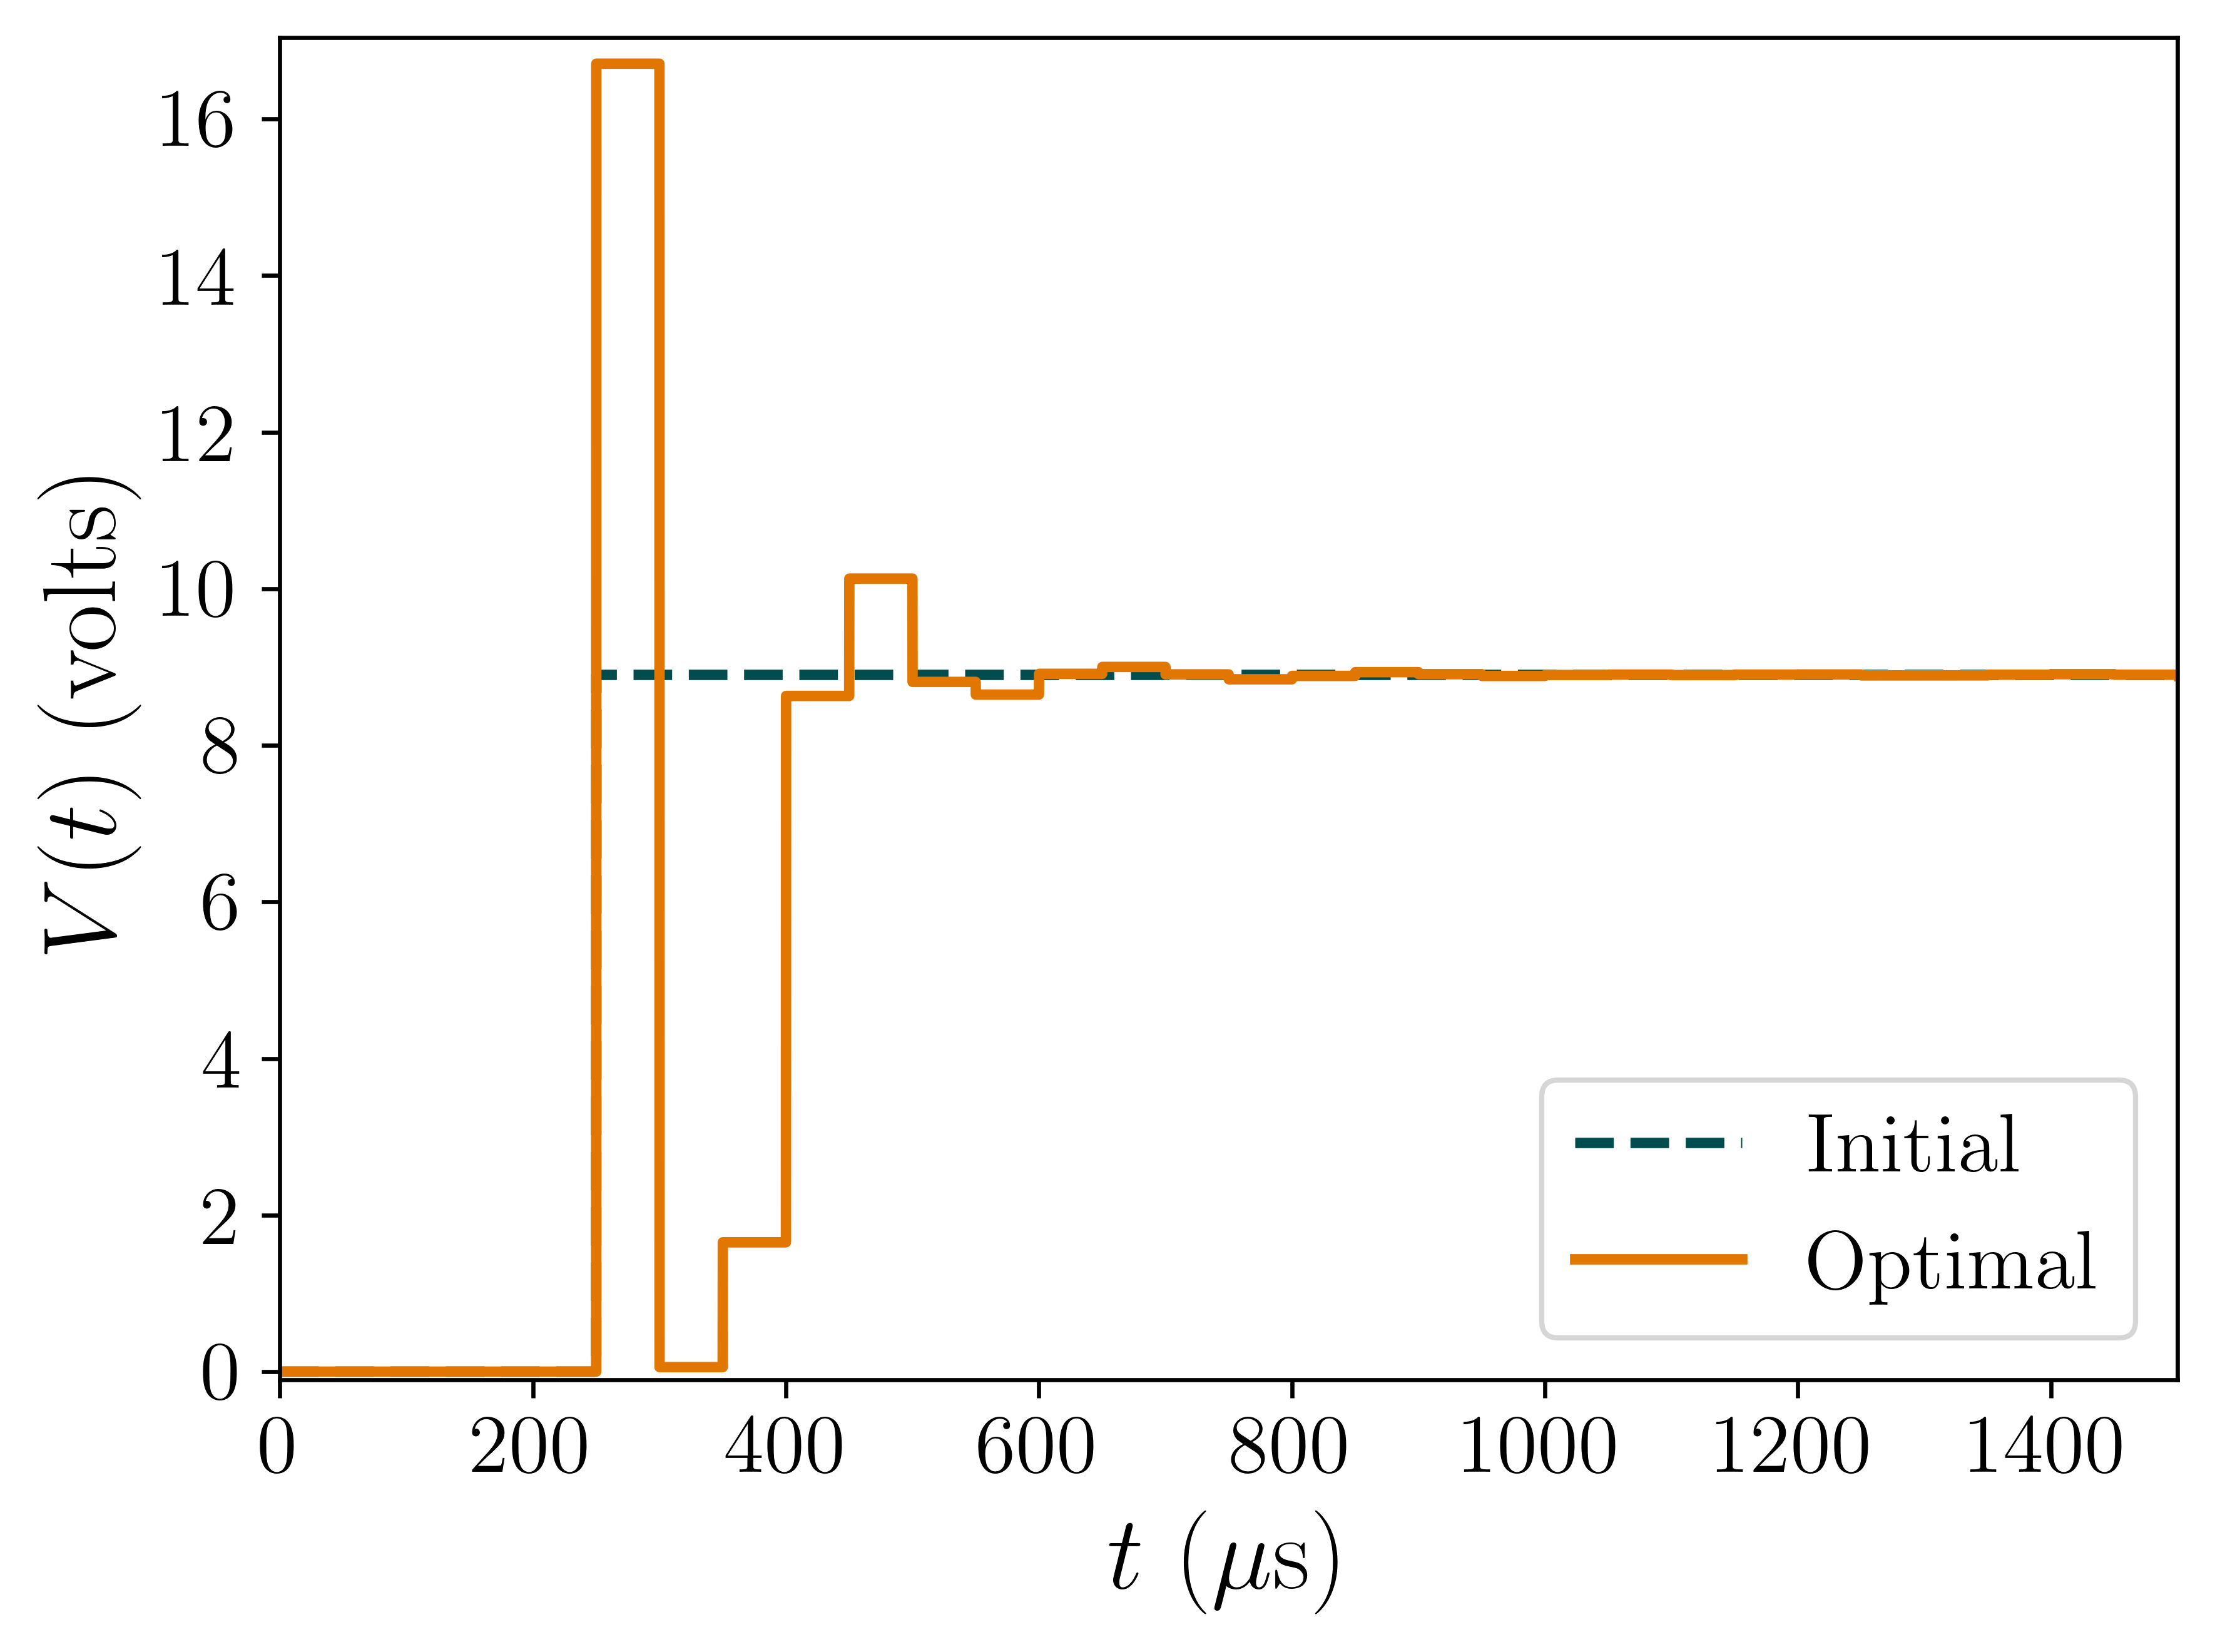

In [25]:
tt = np.linspace(0,T, int(3e4))

fig, ax = plt.subplots()

plt.plot(tt, V(tt,vinit), label='Initial', linewidth=2, linestyle='dashed', color='xkcd:dark teal')
plt.plot(tt, V(tt,vnew), label='Optimal',  linewidth=2, linestyle='solid', color='xkcd:pumpkin')

plt.legend(loc='lower right', fontsize='16')

plt.xlim([0,T])
plt.ylim([-0.1, 1.02*np.amax( V(tt,vnew))])

textcolor = 'k'

plt.xlabel(r"$t$ ($\mu$s)", fontsize=20, color=textcolor)
plt.ylabel(r"$V(t)$ (volts)", fontsize=20, color=textcolor)

plt.tick_params(axis='x', which='both', top=False, color=textcolor)
plt.xticks(fontsize=16, rotation=0, color=textcolor)
plt.tick_params(axis='y', which='both', right=False, color=textcolor)
plt.yticks(fontsize=16, rotation=0, color=textcolor)

fig.set_size_inches(6,4.5)

plt.tight_layout()

#plt.savefig('voltage_schedule_comparision', bbox_inches='tight', dpi=800)

plt.show()

Let's plot the state evolution corresponding to both voltage schedules to see what kind of performance improvement this simple adjustment gives: 

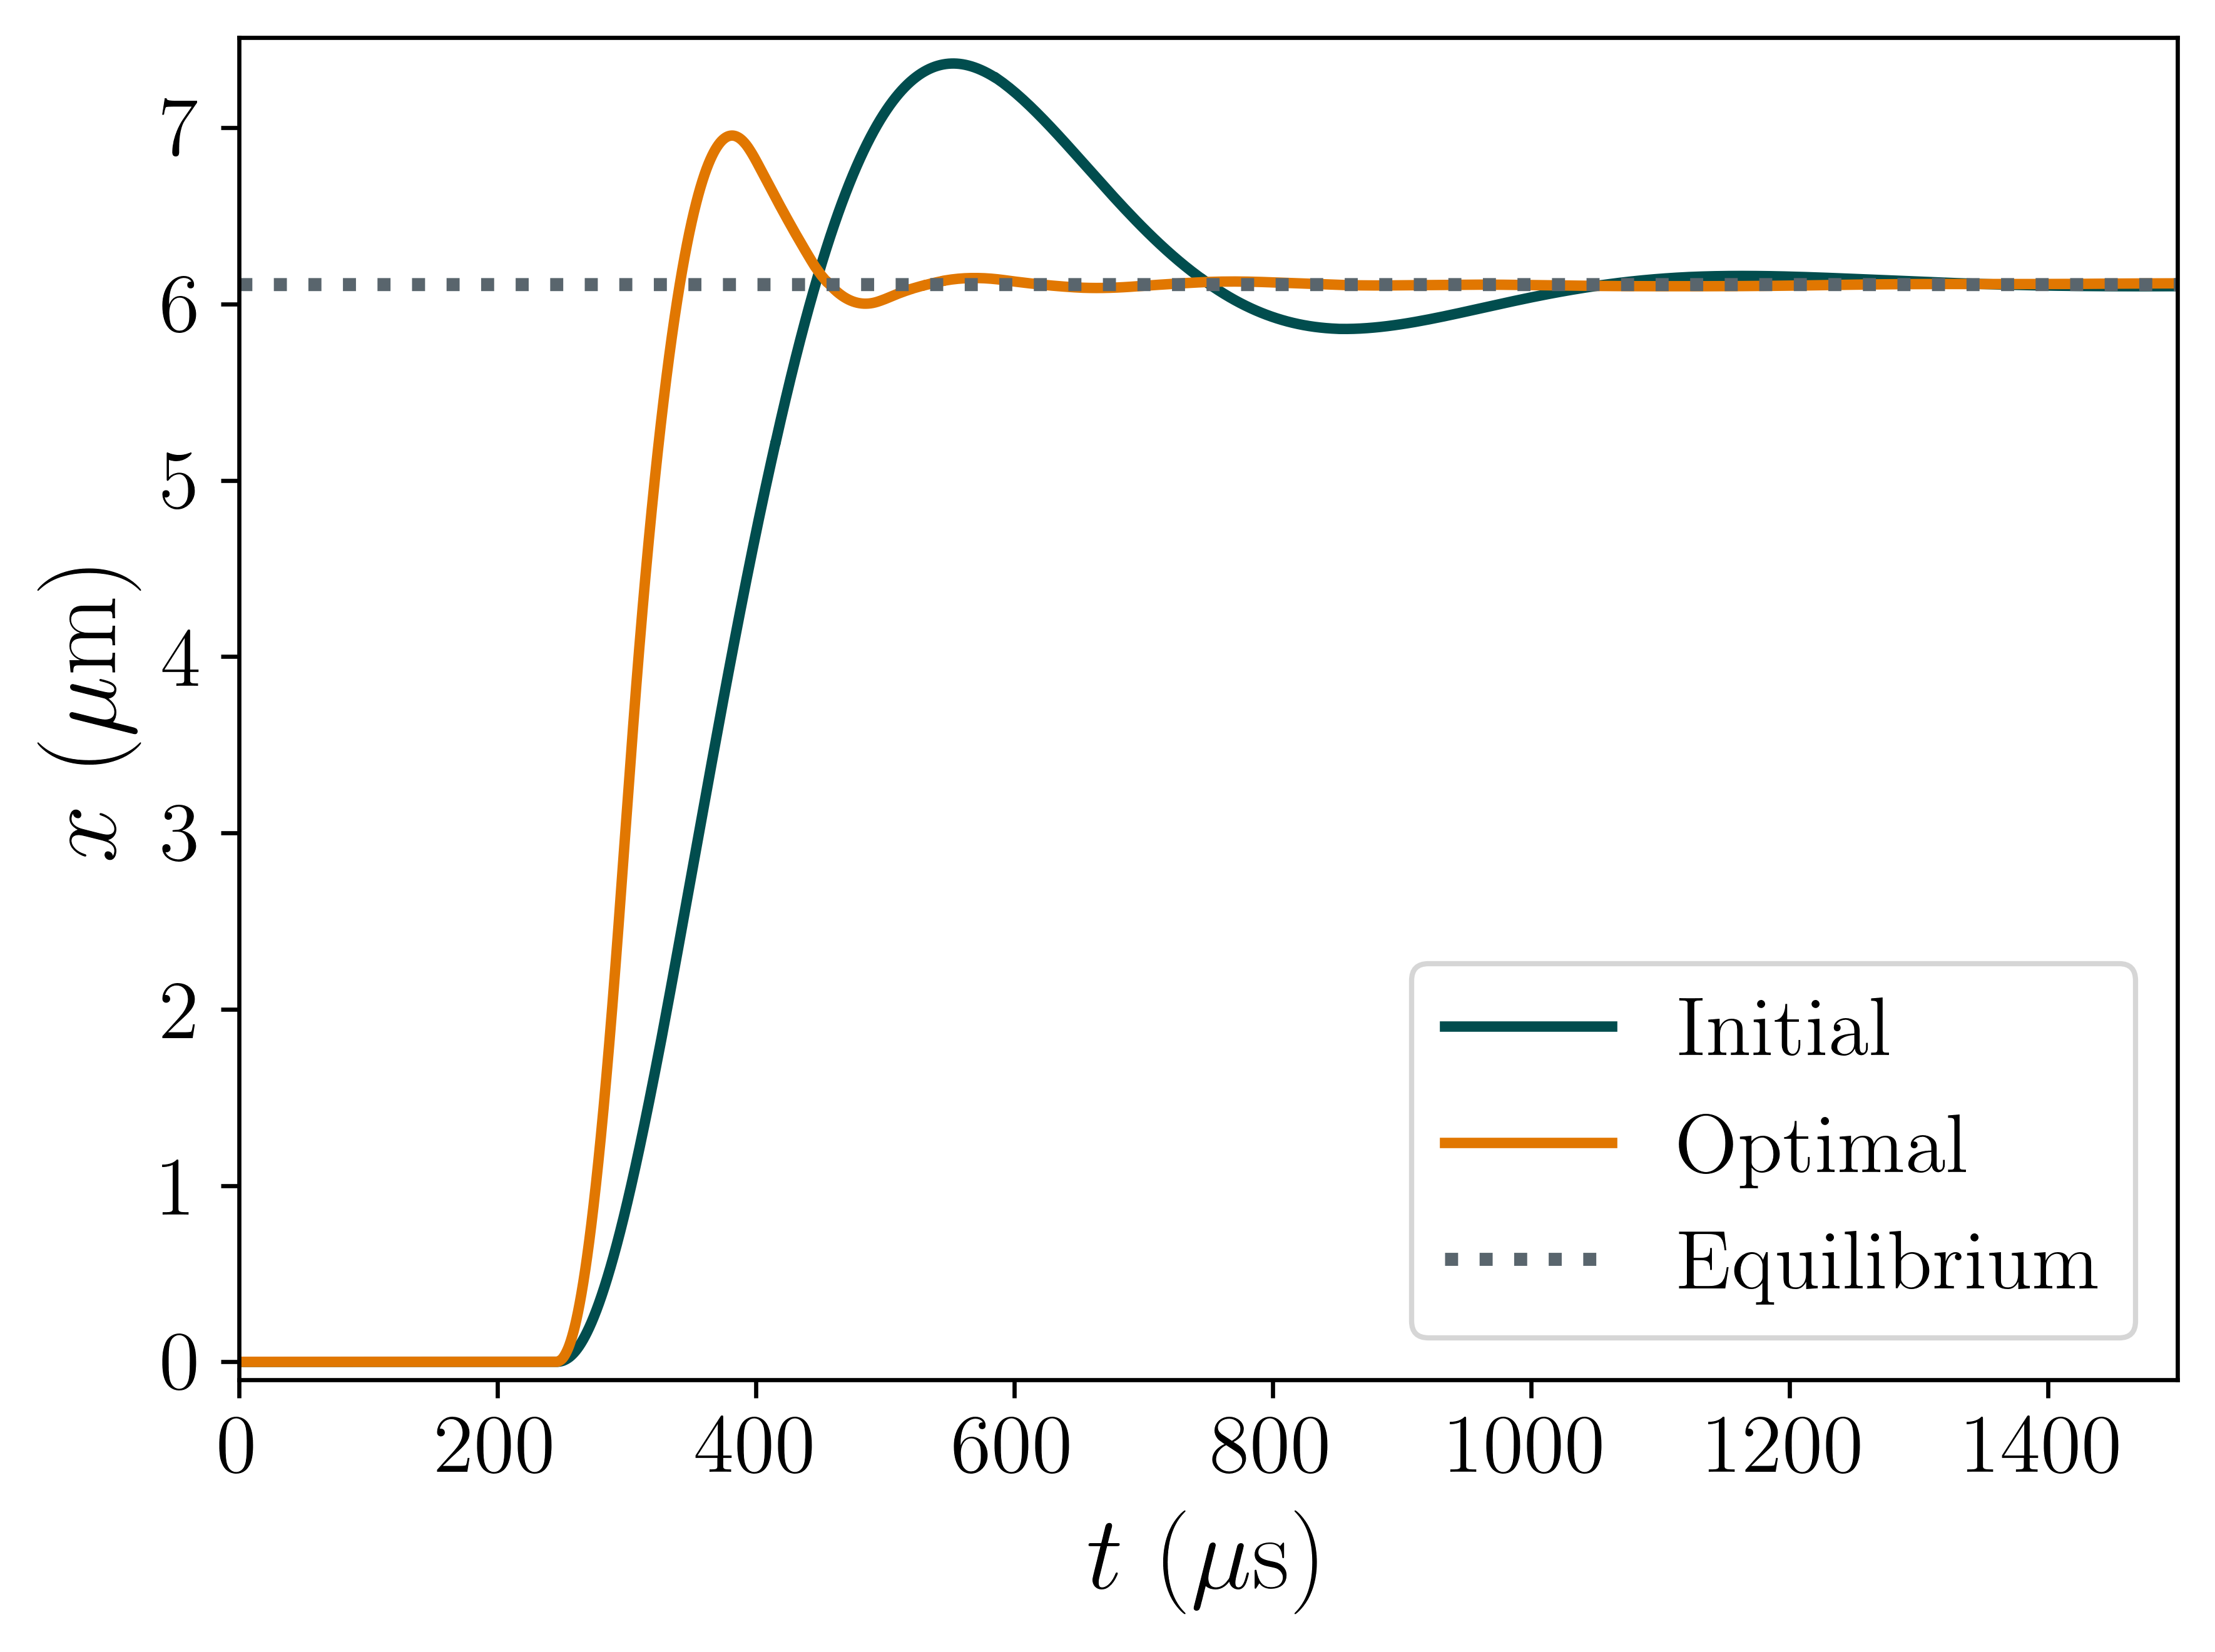

In [26]:
xx_init = initial_state_history(tt)[0,:]
xx = optimal_state_history(tt)[0,:]

fig, ax = plt.subplots()

plt.plot(tt,1e6*xx_init, label='Initial', linewidth=2, linestyle='solid', color='xkcd:dark teal')
plt.plot(tt, 1e6*xx, label='Optimal', linewidth=2, color='xkcd:pumpkin')
plt.plot(tt, 1e6*xf*np.ones_like(tt), label='Equilibrium', linewidth=2.5, linestyle='dotted', color='xkcd:slate grey')
plt.legend(loc='lower right', fontsize='16')

plt.xlim([0,T])
plt.ylim([-0.1, 1.02*np.amax(1e6*xx_init)])

textcolor = 'k'

plt.xlabel(r"$t$ ($\mu$s)", fontsize=20, color=textcolor)
plt.ylabel(r"$x$ ($\mu$m)", fontsize=20, color=textcolor)

plt.tick_params(axis='x', which='both', top=False, color=textcolor)
plt.xticks(fontsize=16, rotation=0, color=textcolor)
plt.tick_params(axis='y', which='both', right=False, color=textcolor)
plt.yticks(fontsize=16, rotation=0, color=textcolor)

fig.set_size_inches(6,4.5)

plt.tight_layout()

#plt.savefig('state_comparison', bbox_inches='tight', dpi=800)

plt.show()

In [27]:
initial_overshoot = (np.amax(xx_init)-xf)/xf
optimal_overshoot = (np.amax(xx)-xf)/xf
print('Initial Design Overshoot = ', 100*initial_overshoot, '%')
print('Optimized Design Overshoot = ', 100*optimal_overshoot, '%')

Initial Design Overshoot =  20.522355120819476 %
Optimized Design Overshoot =  13.834717096139041 %


We see that our optimized design results in a smaller overshoot! This is great news. 

As a sanity check, let's make sure the cost function $J$ is actually decreasing as we iterate. 

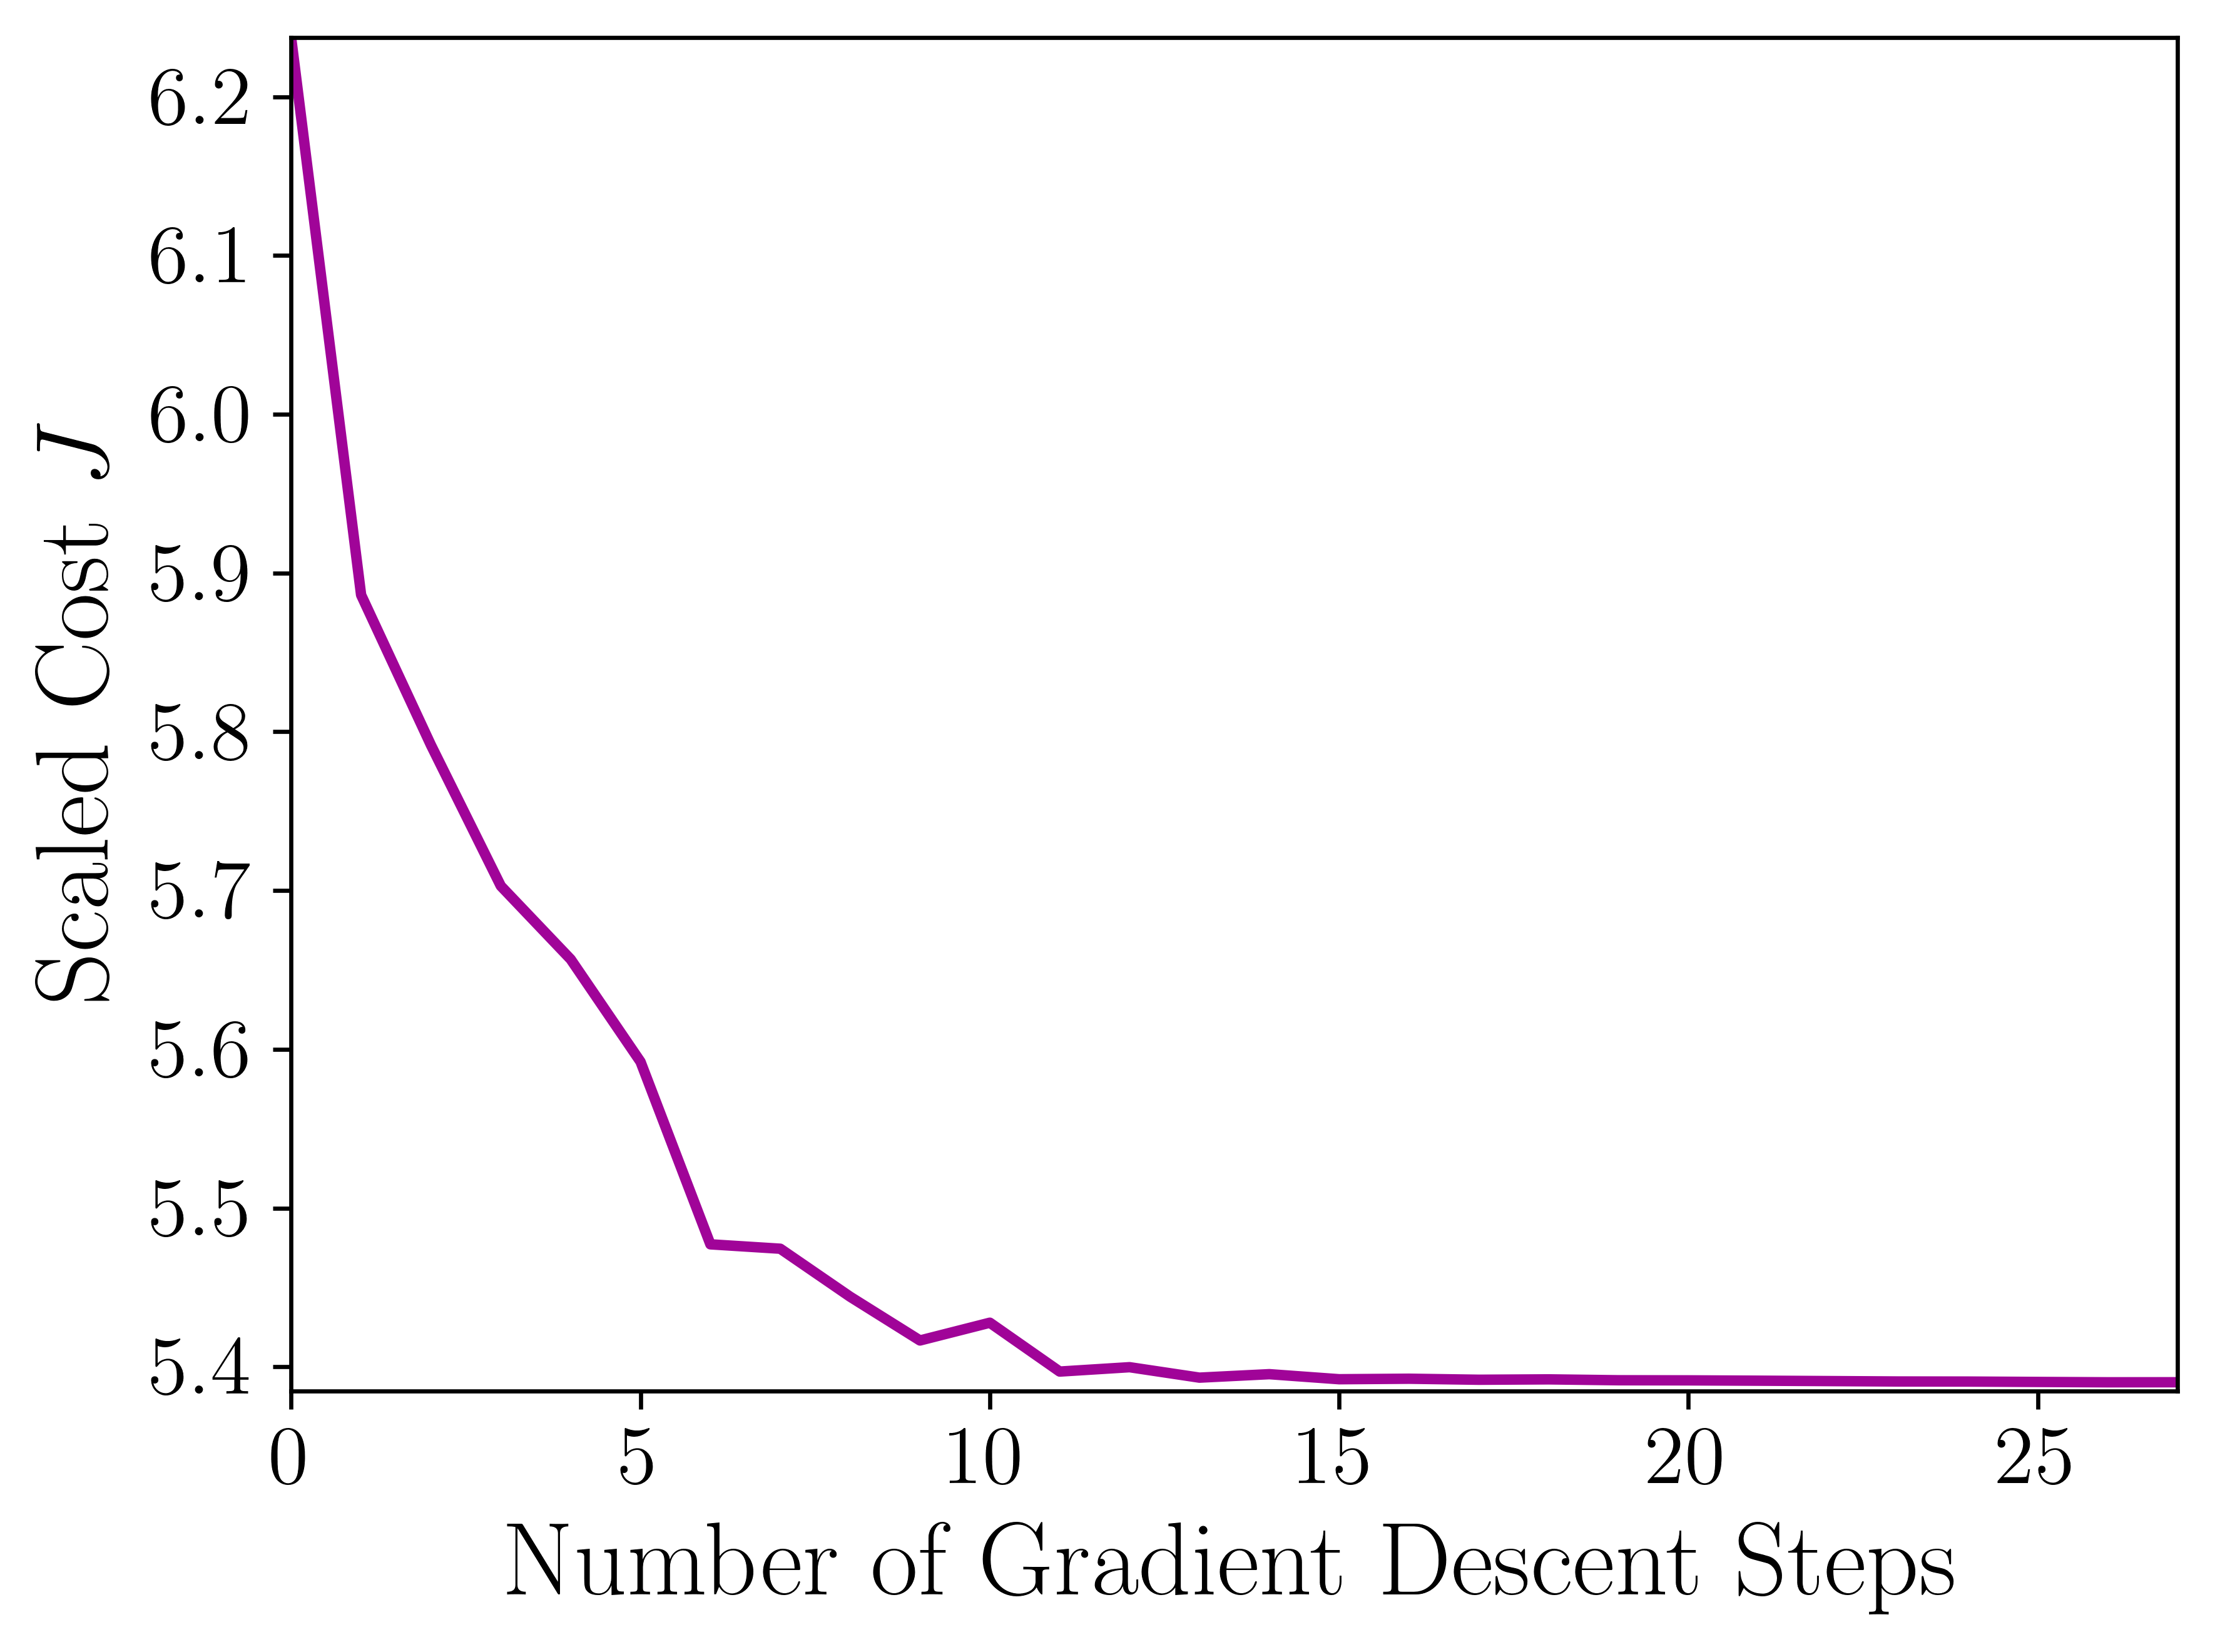

In [28]:
fig, ax = plt.subplots()

cc = 1e9*np.array(cost)

plt.plot(np.arange(0,cnt+1), cc, linewidth=2, color='xkcd:barney purple')

plt.xlim([0,cnt])
plt.ylim([0.999*1e9*np.amin(cost), 1.0001*1e9*np.amax(cost)])

textcolor = 'k'

plt.xlabel(r"Number of Gradient Descent Steps", fontsize=20, color=textcolor)
plt.ylabel(r"Scaled Cost $J$", fontsize=20, color=textcolor)
# TODO: take care of units

plt.tick_params(axis='x', which='both', top=False, color=textcolor)
plt.xticks(fontsize=16, rotation=0, color=textcolor)
plt.tick_params(axis='y', which='both', right=False, color=textcolor)
plt.yticks(fontsize=16, rotation=0, color=textcolor)

fig.set_size_inches(6,4.5)

plt.tight_layout()

#plt.savefig('cost_history', bbox_inches='tight', dpi=800)

plt.show()

The cost function decrease looks pretty good. 

The control strategy suggested by the algorithm is a little "herky-jerky", so for laboratry applications we may wish to adopt a simplified version of the optimal voltage schedule. One such schedule is plotted below: 

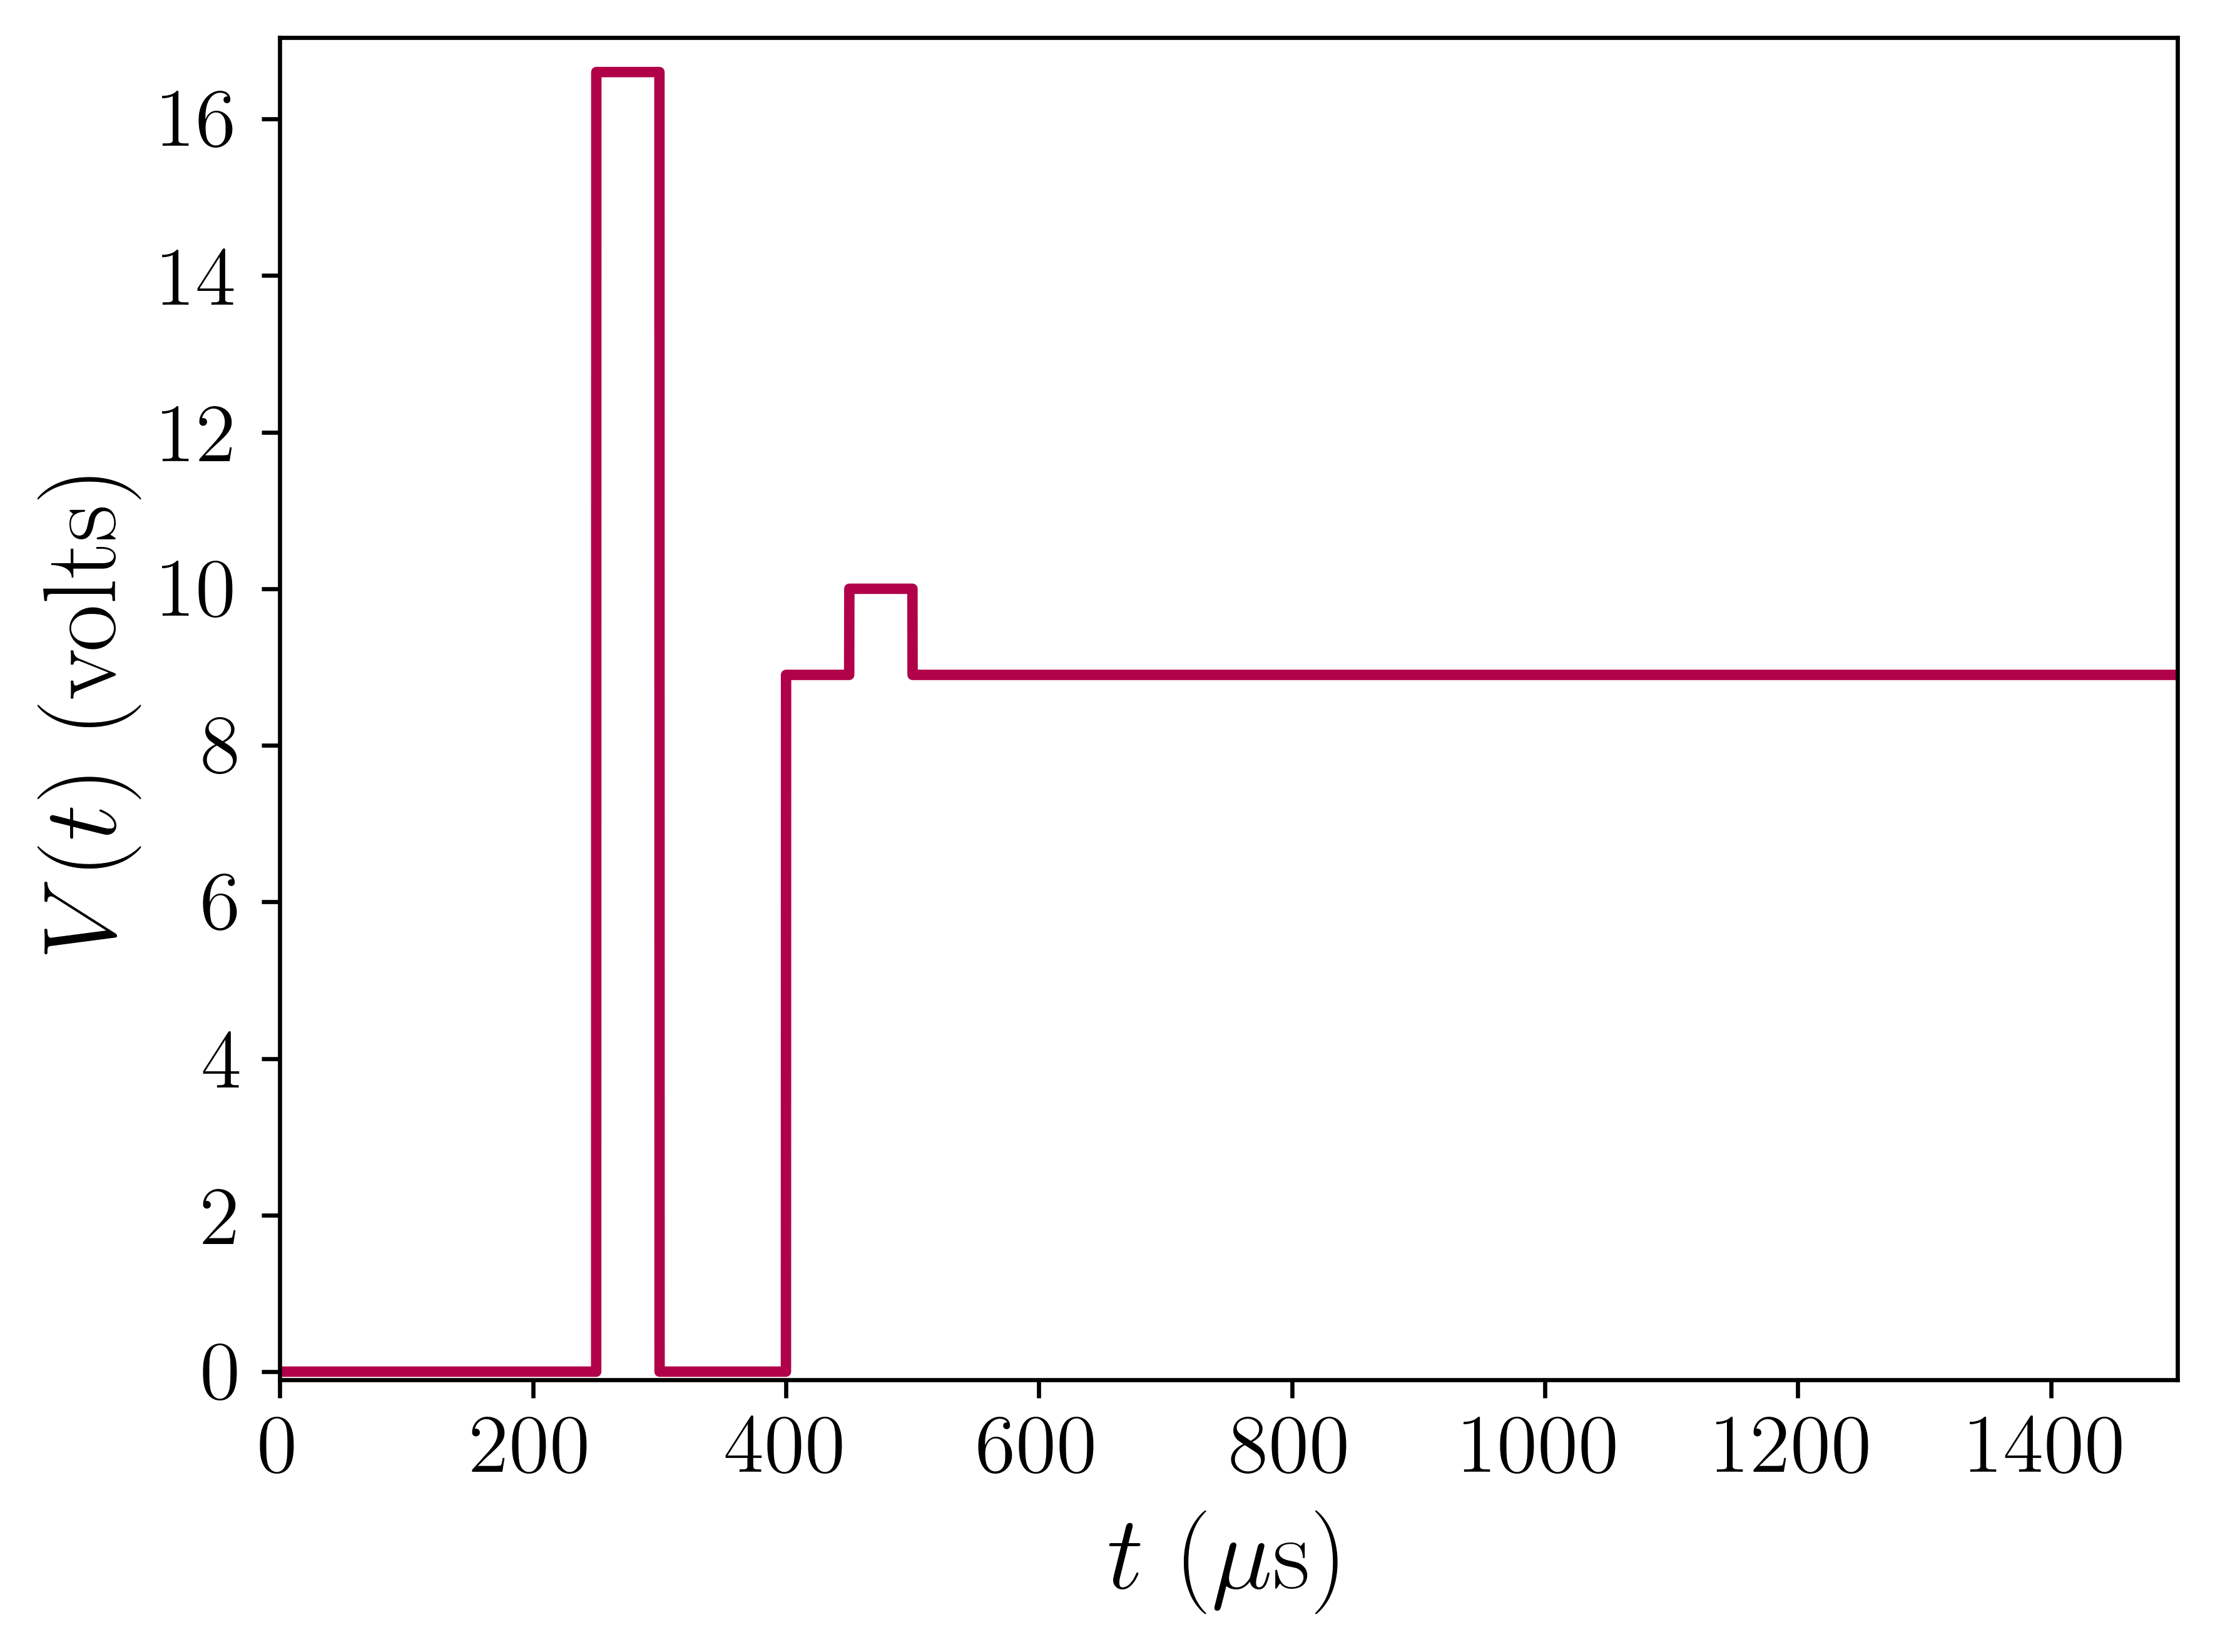

In [29]:
vpractical = np.copy(vnew)
vpractical[5]= 16.6
vpractical[6:8] = 0.
vpractical[8:] = V0
vpractical[9] = 10.

tt = np.linspace(0,T, int(3e4))

fig, ax = plt.subplots()

plt.plot(tt, V(tt, vpractical), label='Simplified Optimal', linewidth=2, linestyle='solid', color='xkcd:raspberry')

plt.xlim([0,T])
plt.ylim([-0.1, 1.02*np.amax( V(tt,vnew))])

textcolor = 'k'

plt.xlabel(r"$t$ ($\mu$s)", fontsize=20, color=textcolor)
plt.ylabel(r"$V(t)$ (volts)", fontsize=20, color=textcolor)

plt.tick_params(axis='x', which='both', top=False, color=textcolor)
plt.xticks(fontsize=16, rotation=0, color=textcolor)
plt.tick_params(axis='y', which='both', right=False, color=textcolor)
plt.yticks(fontsize=16, rotation=0, color=textcolor)

fig.set_size_inches(6,4.5)

plt.tight_layout()

#plt.savefig('voltage_schedule_comparision', bbox_inches='tight', dpi=800)

plt.show()

Let's see how the states corresponding to the optimal and simplified optimal schedules differ. Below, we plot the error between the optimal and simplified optimal states relative to the magnitude of $x_f$ (when the error is positive, the simplified schedule gives an overestimate of the state value). 

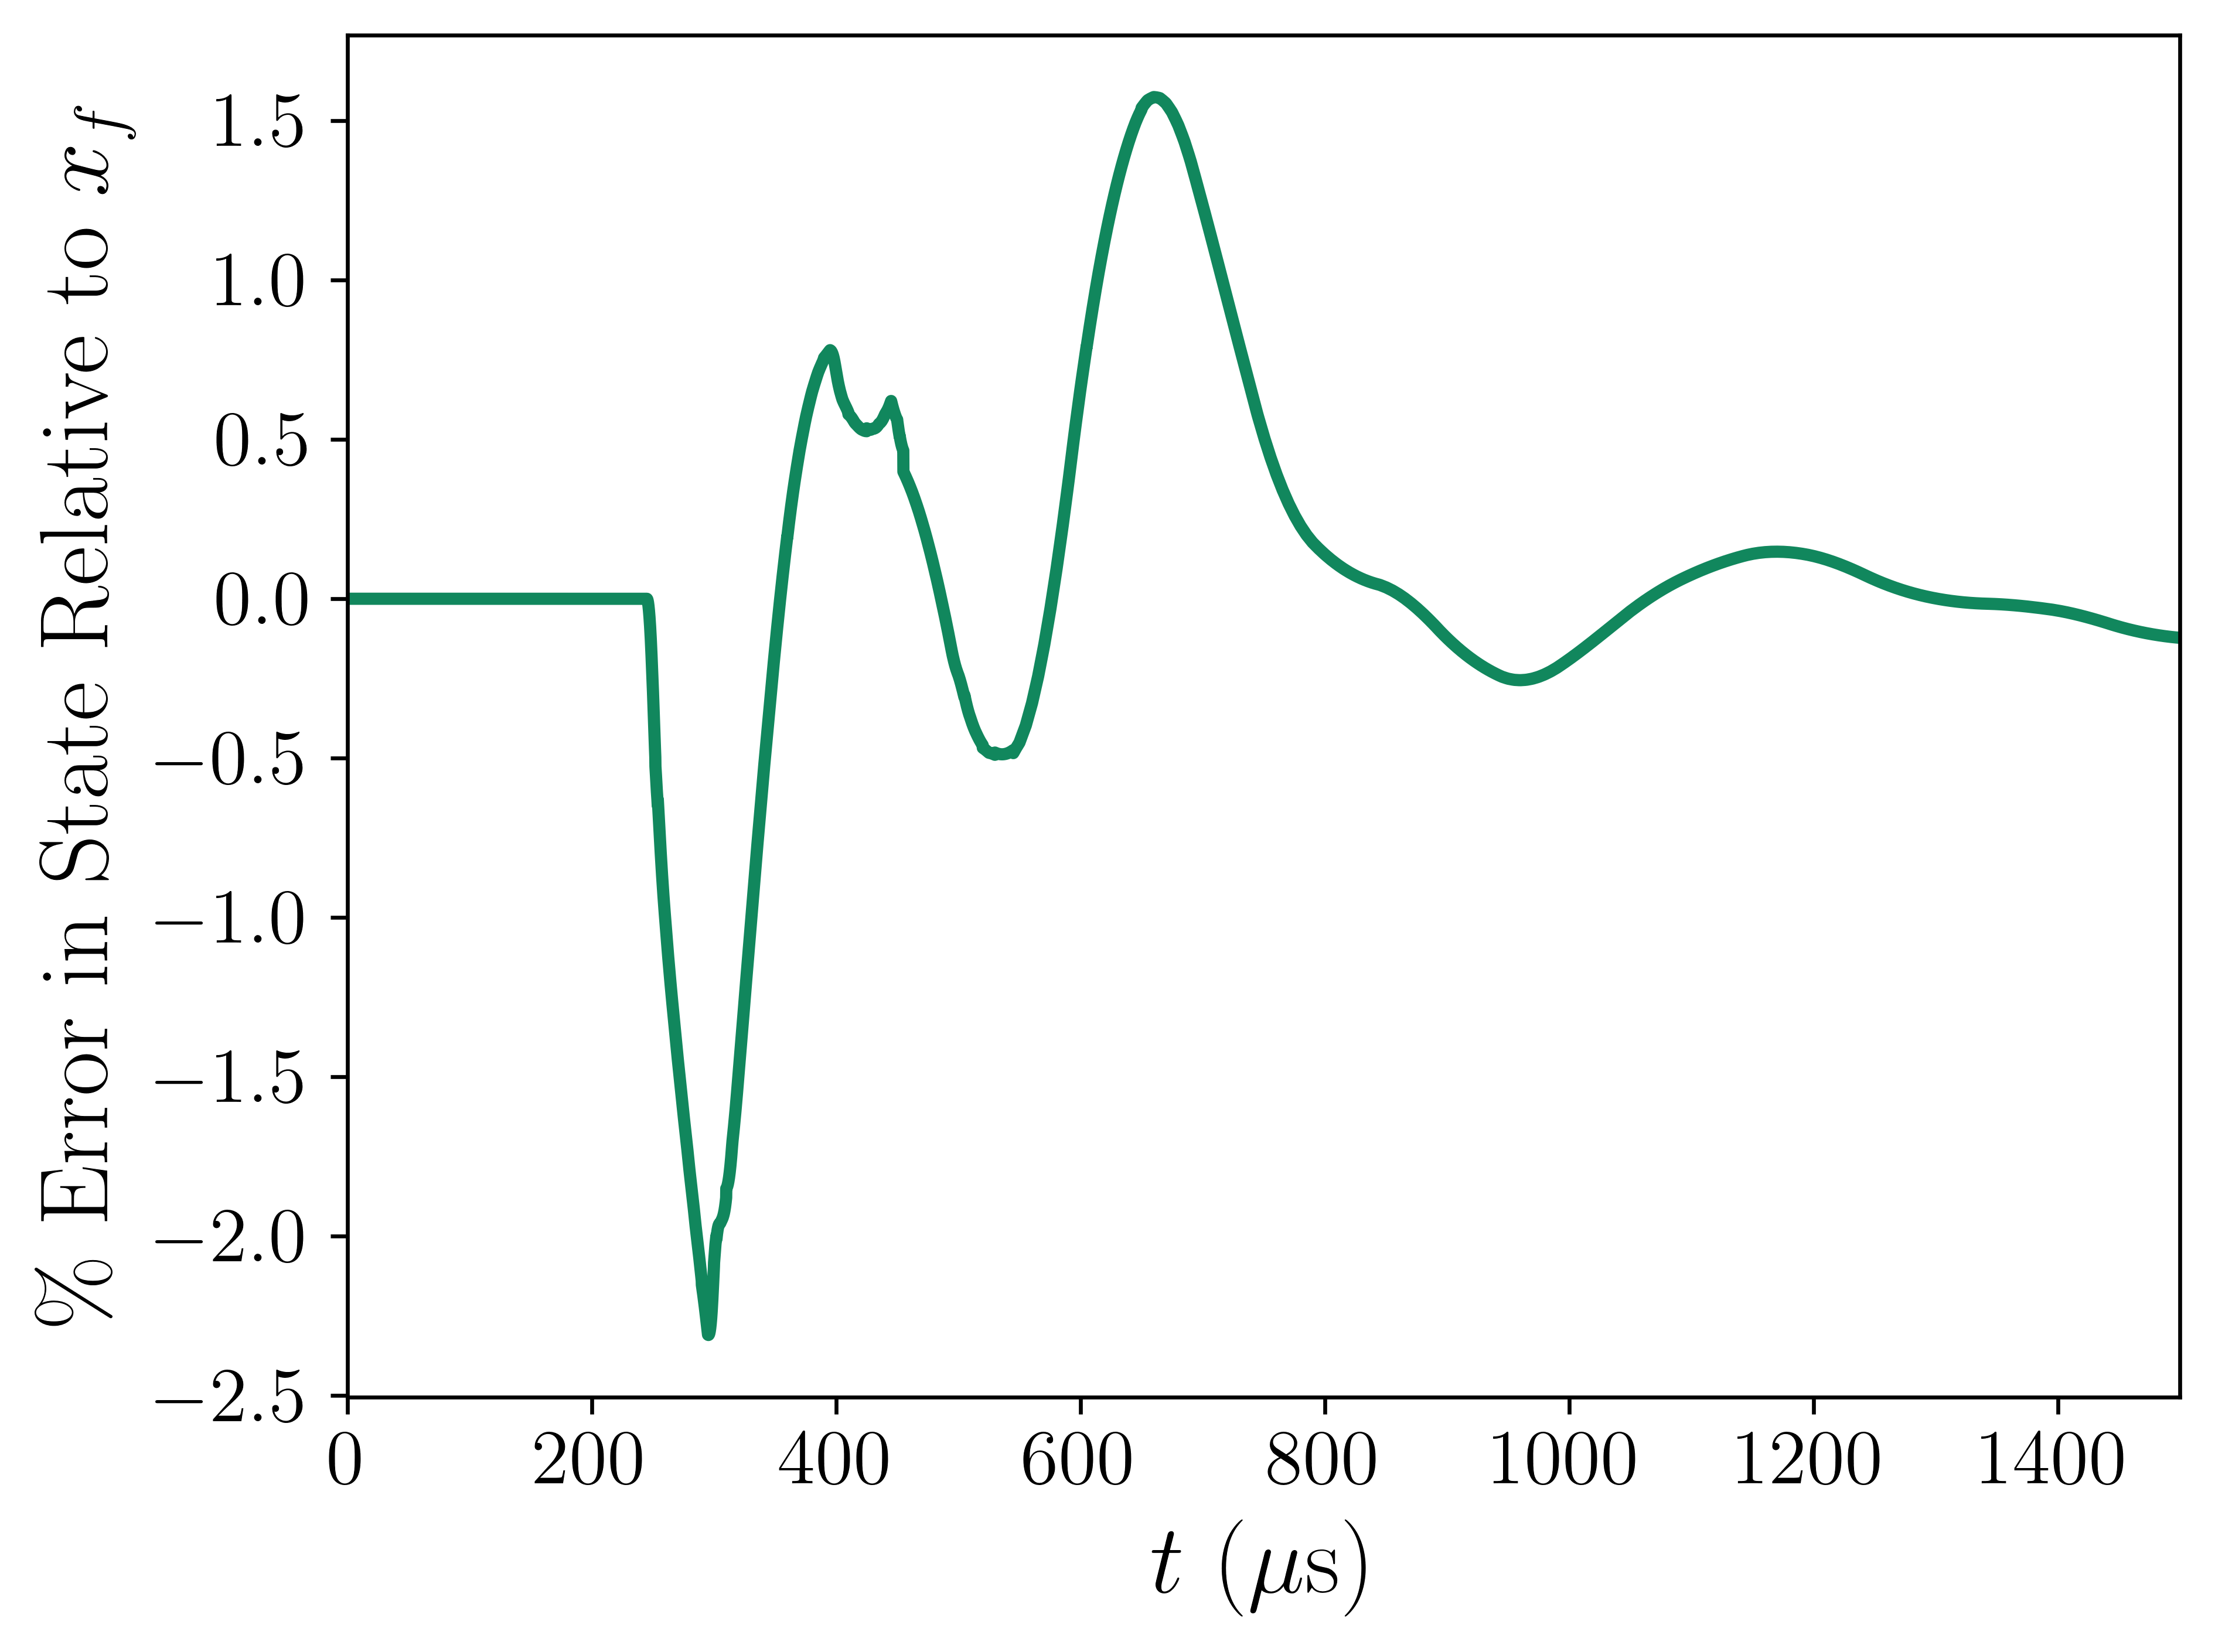

In [30]:
plt.plot(tt, 1e2*(get_state_history(vpractical)(tt)[0]-xx)/xf, linestyle='solid', linewidth=2.5, color='xkcd:dark sea green')

plt.xlim([0,T])
#plt.ylim([-0.5, 1.1])

textcolor = 'k'

plt.xlabel(r"$t$ ($\mu$s)", fontsize=20, color=textcolor)
plt.ylabel(r"$\%$ Error in State Relative to $x_{f}$", fontsize=20, color=textcolor)

plt.tick_params(axis='x', which='both', top=False, color=textcolor)
plt.xticks(fontsize=16, rotation=0, color=textcolor)
plt.tick_params(axis='y', which='both', right=False, color=textcolor)
plt.yticks(fontsize=16, rotation=0, color=textcolor)

fig.set_size_inches(6,4.5)

plt.tight_layout()


plt.show()

We see that the state corresponding to the optimal schedule and the state corresponding to the "practical" schedule agree within a $3\%$ margin. We can also plot both states below to get an even clearer picture: 

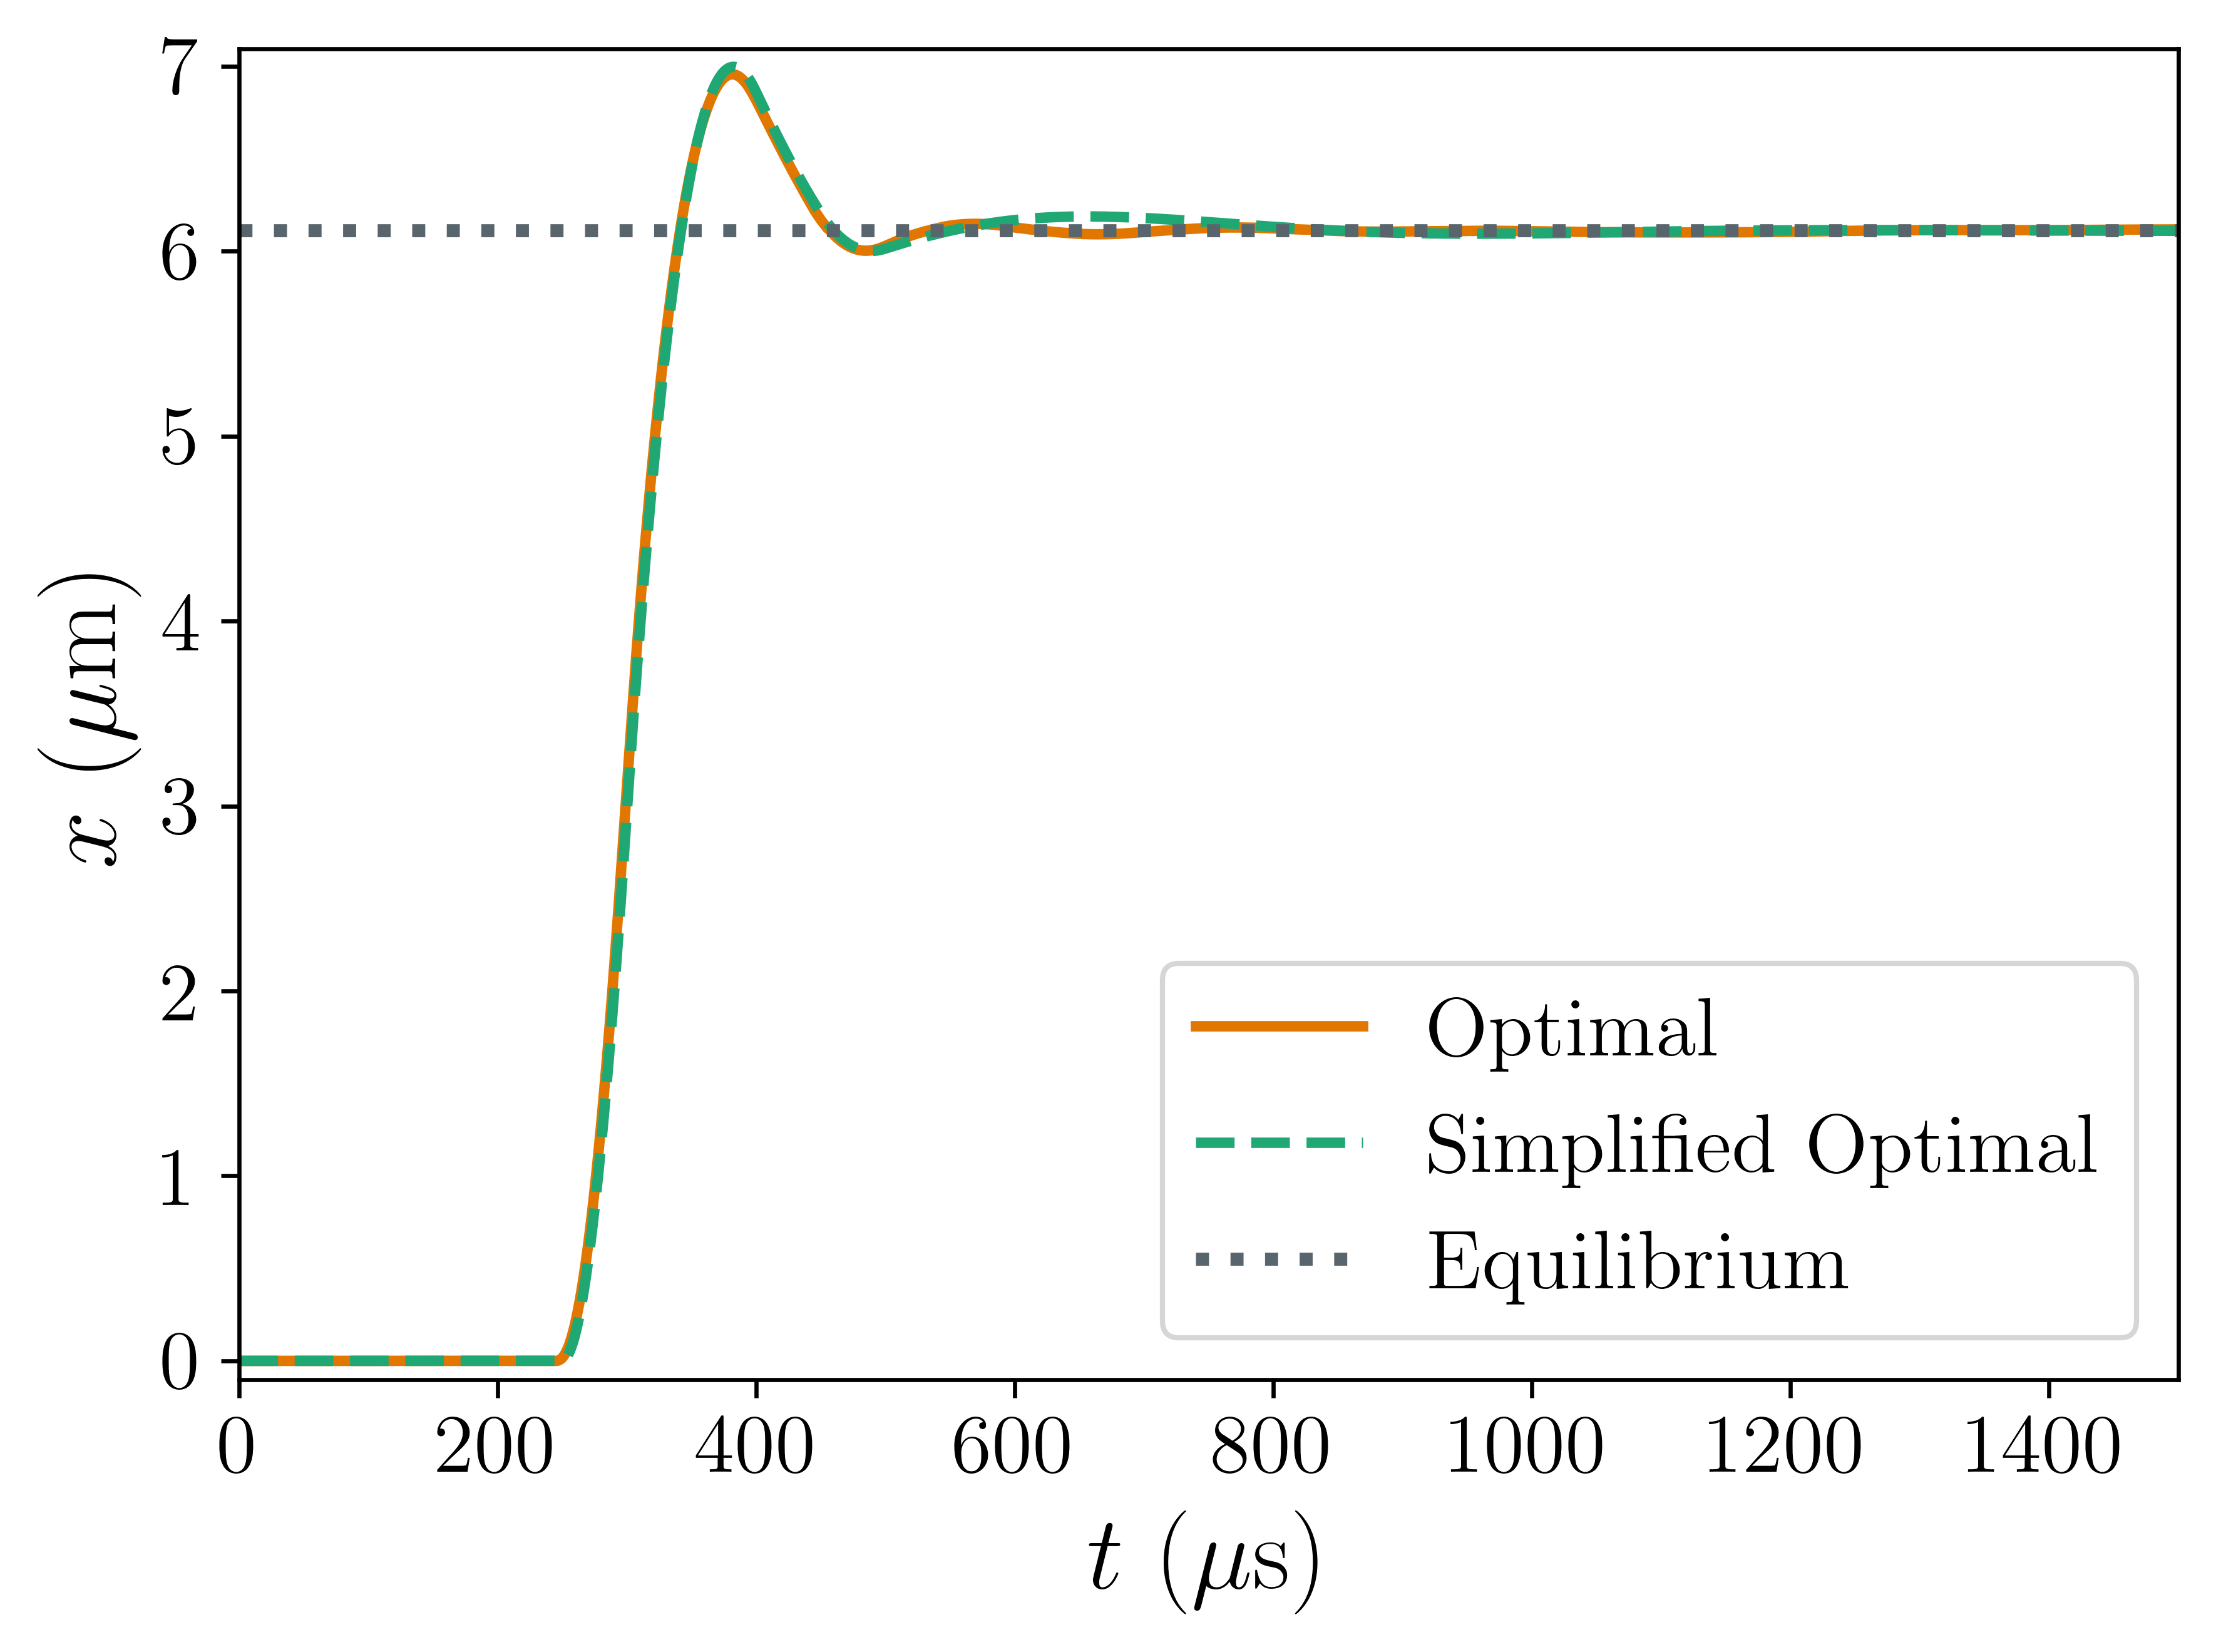

In [31]:
fig, ax = plt.subplots()

#plt.plot(tt,1e6*xx_init, label='Initial', linewidth=2, linestyle='solid', color='xkcd:dark teal')
plt.plot(tt, 1e6*xx, label='Optimal', linewidth=2, color='xkcd:pumpkin')
plt.plot(tt,1e6*get_state_history(vpractical)(tt)[0], label='Simplified Optimal', color='xkcd:jade', linewidth=2, linestyle='dashed')
plt.plot(tt, 1e6*xf*np.ones_like(tt), label='Equilibrium', linewidth=2.5, linestyle='dotted', color='xkcd:slate grey')
plt.legend(loc='lower right', fontsize='16')

plt.xlim([0,T])
plt.ylim([-0.1, 1.02*np.amax(1e6*xx)])

textcolor = 'k'

plt.xlabel(r"$t$ ($\mu$s)", fontsize=20, color=textcolor)
plt.ylabel(r"$x$ ($\mu$m)", fontsize=20, color=textcolor)

plt.tick_params(axis='x', which='both', top=False, color=textcolor)
plt.xticks(fontsize=16, rotation=0, color=textcolor)
plt.tick_params(axis='y', which='both', right=False, color=textcolor)
plt.yticks(fontsize=16, rotation=0, color=textcolor)

fig.set_size_inches(6,4.5)

plt.tight_layout()

#plt.savefig('state_comparison', bbox_inches='tight', dpi=800)

plt.show()

Overall, then, the optimal control approach presented here definitely gives a nice, actionable improvement over the initial voltage schedule $V_{\text{init}}(t)$. In particular, my optimization procedure rediscovers some of the qualitative features of the signal shaping approach of Lewis and Borovic. 

However, there are parts of my method (like step-size reduction for gradient descent, perhaps refinements to the state solver including best practices for choosing max_step) that need some more work. Additionally, while my method produces something that looks like Lewis and Borovic's voltage schedule, it doesn't quite agree. This is a problem because the Lewis and Borovic voltage gives rise to basically zero overshoot. More experimenting (perhaps using a weighted cost function, or even a different initial guess) with my approach is definitely required. 